##### Thermodynamik der chemischen Reaktionsgleichgewichte
*Herwig, Heinz ; Kautz, Christian H.: Technische Thermodynamik. München: Pearson Studium, 2007.*


Definitionen:

In [57]:
import numpy as np
from scipy import integrate

r = 8.3145 # J/(mol °K)
t0_ref = 298.15 # °K

namen = ['CO', 'H2', 'CO2', 'H2O', 'CH4', 'NH3', 'AR', 'O2', 'N2']
elemente = ['C', 'O', 'N', 'H', 'AR']

nuij = np.array([
    [+1, +2, +0, +0, -1, +0, +0, -1 / 2, +0],
    [+1, +3, +0, -1, -1, +0, +0, +0, +0],
    [-1, +1, +1, -1, +0, +0, +0, +0, +0],
    [-1, -3, +0, +1, +1, +0, +0, +0, +0],
    [+0, -4, -1, +2, +1, +0, +0, +0, +0],
    [+0, -3 / 2, 0, 0, +0, +1, +0, +0, -1 / 2]
]).T

ne_dampf = np.array([
    0, 0, 0, 60000, 0, 0, 0, 0, 0
], dtype=float)  # kmol/h
ne_rohgas = np.array([
    0, 0, 0, 0, 20000, 0, 0, 0, 0
], dtype=float)  # kmol/h
ne_luft = np.array([
    0, 0, 0, 0, 0, 0,
    0.01 * 15000,
    0.21 * 15000,
    0.78 * 15000
], dtype=float)  # kmol/h

te_dampf = 500 + 273.15  # °K
te_rohgas = 20 + 273.15  # °K
te_luft = 20 + 273.15  # °K

# Thermochemische Daten

# Barin, Ihsan: Thermochemical Data of Pure Substances.
# Weinheim, New York: VCH, 1993.

h_298 = np.array(
    [-110.541, 0., -393.505,
     -241.826, -74.873, -45.940,
     0., 0., 0.]) * 1000  # J/mol

g_298 = np.array(
    [-169.474, -38.962, -457.240,
     -298.164, -130.393, -103.417,
     -46.167, -61.165, -57.128
     ]) * 1000  # J/mol

# Kritische Parameter Tc, Pc, omega(azentrischer Faktor)

# e.V., VDI: VDI-Wärmeatlas. Wiesbaden: Springer Berlin Heidelberg, 2013.

tc = np.array([
    132.86, 33.19, 304.13,
    647.10, 190.56, 405.50,
    150.69, 154.60, 126.19
])  # K

pc = np.array([
    34.98, 13.15, 73.77,
    220.64, 45.99, 113.59,
    48.63, 50.46, 33.96
])  # bar

omega_af = np.array([
    0.050, -0.219, 0.224,
    0.344, 0.011, 0.256,
    -0.002, 0.022, 0.037
])
# umformen (reshape), um direkte Division zu ermöglichen
mm = np.array([
    28.01, 2.02, 44.01,
    18.02, 16.04, 17.03,
    39.95, 32.00, 28.01
]).reshape([len(namen), 1])

# Koeffizienten für Cp(T)/R = B+(C-B)(T/(A+T))^2*(
# 1-A/(A+T)*(D+E*T/(A+T)+F*(T/(A+T))^2+G*(T/(A+T))^3))
# Nach rechts hin: A, B, C, D

# e.V., VDI: VDI-Wärmeatlas. Wiesbaden: Springer Berlin Heidelberg, 2013.

cp_coefs = np.array([z for z in [
    [
        y.replace(',', '.').replace('–', '-') for y in x.split('  ')
    ] for x in """
407,9796  3,5028  2,8524  –2,3018  32,9055  –100,1815  106,1141
392,8422  2,4906  –3,6262  –1,9624  35,6197  –81,3691  62,6668
514,5073  3,4923  –0,9306  –6,0861  54,1586  –97,5157  70,9687
706,3032  5,1703  –6,0865  –6,6011  36,2723  –63,0965  46,2085
1530,8043  4,2038  –16,6150  –3,5668  43,0563  –86,5507  65,5986
931,6298  4,8468  –7,1757  –7,6727  51,3877  –93,4217  67,9515
0,0000  2,5000  2,5000  0,0000  0,0000  0,0000  0,0000
2122,2098  3,5302  –7,1076  –1,4542  30,6057  –83,6696  79,4375
432,2027  3,5160  2,8021  –4,1924  42,0153  –114,2500  111,1019
""".split('\n') if len(x) > 0] if len(z) > 1], dtype=float)


def cp_durch_r(t, component=-1):
    if component != -1:
        cp_c_temp = cp_coefs[component, :]
        a, b, c, d, e, f, g = np.split(cp_c_temp, len(cp_c_temp), axis=0)
    else:
        a, b, c, d, e, f, g = np.split(cp_coefs, cp_coefs.shape[1], axis=1)
    return b + (c - b) * (t / (a + t))**2 * (
        1 - a / (a + t) * (
            d + e * t / (a + t) + f * (t / (a + t))**2 + g * (t / (a + t))**3
        ))  # dimensionslos

# Berechne H(T), G(T) und K(T) mit Cp(T)


def h(t):
    enthalpien = np.empty_like(h_298)
    for i in range(len(enthalpien)):
        int_cp_durch_r = integrate.quad(
            lambda temp: cp_durch_r(temp, i), 298.15, t)[0]
        enthalpien[i] = h_298[i] + r * int_cp_durch_r
    return enthalpien  # J/mol


def g(t, h_t):
    freie_energien = np.empty_like(h_298)
    for i in range(len(freie_energien)):
        int_cp_durch_rt = integrate.quad(
            lambda temp: cp_durch_r(temp, i) / temp, 298.15, t)[0]
        freie_energien[i] = \
            h_t[i] - \
            t / t0_ref * (h_298[i] - g_298[i]) - r * t * int_cp_durch_rt
    return freie_energien  # J/mol


Ammoniaksynthesereaktion bei 400°C=673,15°K

$3 H_2 + N2 \rightleftharpoons NH_3$

In [103]:
namen

['CO', 'H2', 'CO2', 'H2O', 'CH4', 'NH3', 'AR', 'O2', 'N2']

In [106]:
nuij = np.array([
    [+0, -3 , 0, 0, 0, +2, +0, +0, -1]
])

delta_h_298 = nuij.dot(h_298).item()/1000. # kJ/mol
delta_g_298 = nuij.dot(g_298).item()/1000. # kJ/mol
delta_cp_298 = r * nuij.dot(
    cp_durch_r(298.15)).item() # J/(mol °K)
k_298 = np.exp(
    -delta_g_298*1000/(r * (298.15))
).item()

h_400 = h(400 + 273.15)
g_400 = g(400 + 273.15, h_400 )
delta_h_400 = nuij.dot(h_400).item()/1000. # kJ/mol
delta_g_400 = nuij.dot(g_400).item()/1000. # kJ/mol
delta_cp_400 = r * nuij.dot(
    cp_durch_r(400+273.15)).item() # J/(mol °K)
k_400 = np.exp(
    -delta_g_400*1000/(r * (400 + 273.15))
).item()

def print_variable(name, units):
    print(name + '= ' + 
          '{:15.6}'.format(globals()[name]) + 
          ' ' + units)
print_variable('delta_g_298', 'kJ/mol')
print_variable('delta_h_298', 'kJ/mol')
print_variable('delta_cp_298', 'J/(mol °K)')
print_variable('k_298', '')
print('')
print_variable('delta_g_400', 'kJ/mol')
print_variable('delta_h_400', 'kJ/mol')
print_variable('delta_cp_400', 'J/(mol °K)')
print_variable('k_400', '')

delta_g_298=          -32.82 kJ/mol
delta_h_298=          -91.88 kJ/mol
delta_cp_298=        -44.8032 J/(mol °K)
k_298=     5.62069e+05 

delta_g_400=         48.1856 kJ/mol
delta_h_400=         -104.56 kJ/mol
delta_cp_400=        -22.8273 J/(mol °K)
k_400=     0.000182396 


Knallgasreaktion bei 300°K - 5000°K 

$ H_2O \rightleftharpoons H_2 + \frac{1}{2}O_2$

In [102]:
namen

['CO', 'H2', 'CO2', 'H2O', 'CH4', 'NH3', 'AR', 'O2', 'N2']

In [214]:
nuij = np.array([
    [0, +1 , 0, -1, 0, 0, 0, +1 / 2, 0]
])

delta_h_298 = nuij.dot(h_298).item()/1000. # kJ/mol
delta_g_298 = nuij.dot(g_298).item()/1000. # kJ/mol
delta_cp_298 = r * nuij.dot(
    cp_durch_r(298.15)).item() # J/(mol °K)
k_298 = np.exp(
    -delta_g_298*1000/(r * (298.15))
).item()

h_5000 = h(5000 + 273.15)
g_5000 = g(5000 + 273.15, h_5000 )
delta_h_5000 = nuij.dot(h_5000).item()/1000. # kJ/mol
delta_g_5000 = nuij.dot(g_5000).item()/1000. # kJ/mol
delta_cp_5000 = r * nuij.dot(
    cp_durch_r(5000+273.15)).item() # J/(mol °K)
k_5000 = np.exp(
    -delta_g_5000*1000/(r * (5000 + 273.15))
).item()

def print_variable(name, units):
    print(name + '= ' + 
          '{:15.6}'.format(globals()[name]) + 
          ' ' + units)
print_variable('delta_g_298', 'kJ/mol')
print_variable('delta_h_298', 'kJ/mol')
print_variable('delta_cp_298', 'J/(mol °K)')
print_variable('k_298', '')
print('')
print_variable('delta_g_5000', 'kJ/mol')
print_variable('delta_h_5000', 'kJ/mol')
print_variable('delta_cp_5000', 'J/(mol °K)')
print_variable('k_5000', '')

temp = np.linspace(300, 5000, 50)
h_300_5000 = np.array([h(t) for t in temp])
g_300_5000 = np.array([g(t, h_300_5000[k]) 
                       for k, t in enumerate(temp)])
delta_h_t = np.array(
    [nuij.dot(h_k)/1000. for h_k in h_300_5000]).flatten()
delta_g_t = np.array(
    [nuij.dot(g_k)/1000. for g_k in g_300_5000]).flatten()
t_delta_s_t = np.array([
    (delta_h_t[k]-delta_g_t[k])
    for k in range(len(temp))]).flatten()
t_bei_null_g = -np.interp(0, -delta_g_t, -temp)

delta_g_298=         228.619 kJ/mol
delta_h_298=         241.826 kJ/mol
delta_cp_298=         10.0002 J/(mol °K)
k_298=       8.867e-41 

delta_g_5000=        -44.8427 kJ/mol
delta_h_5000=         246.883 kJ/mol
delta_cp_5000=         6.84434 J/(mol °K)
k_5000=         2.78094 


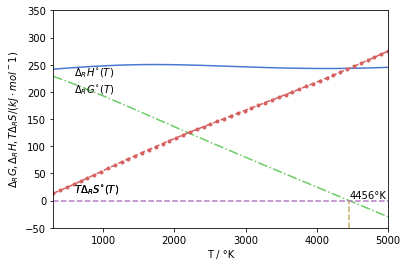

In [219]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ax.plot(temp, delta_h_t, '-', 
         temp, delta_g_t, '-.', 
         temp, t_delta_s_t, '--.')
ax.annotate('$\Delta_R H^{\circ}(T)$', 
           xy=(lines[0].get_data()[0][3],
              lines[0].get_data()[1][3]-15), 
           xycoords='data')
ax.annotate('$\Delta_R G^{\circ}(T)$', 
           xy=(lines[1].get_data()[0][3],
              lines[1].get_data()[1][3]-15), 
           xycoords='data')
ax.annotate('$T\Delta_R S^{\circ}(T)$', 
           xy=(lines[2].get_data()[0][3],
              lines[2].get_data()[1][3]-15), 
           xycoords='data')
ax.set_xlabel('T / °K')
ax.set_ylabel('$\Delta_R G, \Delta_R H, T \Delta_R S '
             + ' / (kJ \cdot mol^-1)$')
ax.annotate('$T\Delta_R S^{\circ}(T)$', 
           xy=(lines[2].get_data()[0][3],
              lines[2].get_data()[1][3]-15), 
           xycoords='data')
ax.annotate('{:0.4g}'.format(t_bei_null_g) + '°K', 
           xy=(t_bei_null_g, 0+5.0), 
           xycoords='data')
ax.plot([300, 5000], [0,0], '--')
ax.plot([t_bei_null_g, t_bei_null_g], [-50,0], '--')
ax.set_ylim([-50,350])
ax.set_xlim([300,5000]);